# Classificador de tênis (Nike vs Adidas)

In [120]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

## Carregamento de dados dos datasets.

In [121]:
from sklearn.model_selection import train_test_split

def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    train_dir = os.path.join(data_dir, "NewTrain")
    train_data = ImageFolder(root=train_dir, transform=transform)

    # Get the indices of train and test samples
    train_indices, test_indices = train_test_split(
        range(len(train_data)), test_size=0.33, random_state=42
    )

    # Create data subsets
    train_subset = Subset(train_data, train_indices)
    test_subset = Subset(train_data, test_indices)

    # Create data loaders
    training_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_subset, batch_size=batch_size, shuffle=False
    )

    return training_loader, test_loader

In [122]:
data_dir = "Dataset"
train_loader, test_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [123]:
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")
#print("Classes no conjunto de treinamento:")
#print(train_loader.dataset.samples)

Número de amostras de treinamento: 377
Número de amostras de teste: 187


In [124]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = nn.Linear(2048, 2)
resnet = resnet.to(device)

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métodos 

### Matriz de confusão

In [125]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

### Acurácia

In [126]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

### F1 Score

In [127]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return f1_score(true_labels, predicted_labels, average='macro')

### ROC AUC métrica

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_roc_auc_score(model, loader, n_classes):
    model.eval()
    true_labels = []
    predicted_probs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())
    true_labels = label_binarize(true_labels, classes=[i for i in range(n_classes)])
    return roc_auc_score(true_labels, predicted_probs, multi_class='ovr')

### Validação

In [129]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss +=loss
    return val_loss/len(loader)

### Regularização

l1_lambda e l2 lambda são os pesos/intensidade que a regularização aplicará no modelo.

In [130]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [131]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

### Treinamento

In [132]:
def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)
            loss += l1_reg
            l2_reg = l2_regularization(model, l2_lambda, device)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch+1} | Loss: {running_loss/len(trainloader)} | Val Loss: {val_loss}')

## Registro de evoluções nos modelos
- 1º modelo era treinado com apenas 3 épocas e com learning rate de 0,001. **Acurácia de 70%**.
- 2º modelo subimos o número de épocas para 30 (número baseado nos modelos analisados da referência 1) e ajustamos o learning rate para 0,0001. **Acurácia de 88%**.
- 3º modelo inserimos regularização L1 e L2 com peso da regularização de 0,01. **Acurácia caiu para 76%**
- 4º modelo ajustamos os parâmetros de pesos da regularização L1 e L2 para de 0,00001. **Acurácia de 90%**

Referências:  
1 - https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset/code

In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
l1_lambda = 0.0001
l2_lambda = 0.0001
epochs = 30

## Treinamento

In [134]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=l1_lambda, l2_lambda=l2_lambda)

  0%|          | 0/32 [00:00<?, ?it/s]

 31%|███▏      | 10/32 [00:04<00:08,  2.68it/s]c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Epoch: 1 | Loss: 27.448494493961334 | Val Loss: 0.35553136467933655


100%|██████████| 32/32 [00:11<00:00,  2.91it/s]


Epoch: 2 | Loss: 26.194783926010132 | Val Loss: 0.16501106321811676


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch: 3 | Loss: 25.14391154050827 | Val Loss: 0.1407821625471115


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch: 4 | Loss: 24.05941081047058 | Val Loss: 0.39362236857414246


100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Epoch: 5 | Loss: 23.013822734355927 | Val Loss: 0.1599707007408142


100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


Epoch: 6 | Loss: 21.924455404281616 | Val Loss: 0.1843753159046173


100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch: 7 | Loss: 20.90865331888199 | Val Loss: 0.16543565690517426


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Epoch: 8 | Loss: 19.890487670898438 | Val Loss: 0.18289776146411896


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 9 | Loss: 18.94516009092331 | Val Loss: 0.18909813463687897


100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Epoch: 10 | Loss: 18.015734910964966 | Val Loss: 0.15022948384284973


100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


Epoch: 11 | Loss: 17.254152953624725 | Val Loss: 0.2124256044626236


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Epoch: 12 | Loss: 16.636413097381592 | Val Loss: 0.48872002959251404


100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Epoch: 13 | Loss: 16.367608308792114 | Val Loss: 0.2619026303291321


100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


Epoch: 14 | Loss: 15.73658737540245 | Val Loss: 0.3987376093864441


100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


Epoch: 15 | Loss: 15.000255316495895 | Val Loss: 0.10305337607860565


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 16 | Loss: 14.509858906269073 | Val Loss: 0.1970970332622528


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 17 | Loss: 13.94856134057045 | Val Loss: 0.131090447306633


100%|██████████| 32/32 [00:11<00:00,  2.91it/s]


Epoch: 18 | Loss: 13.367806226015091 | Val Loss: 0.11318102478981018


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 19 | Loss: 12.841779738664627 | Val Loss: 0.14967241883277893


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 20 | Loss: 12.381237775087357 | Val Loss: 0.09927904605865479


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 21 | Loss: 11.996837168931961 | Val Loss: 0.12823975086212158


100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


Epoch: 22 | Loss: 11.756266832351685 | Val Loss: 0.13231509923934937


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 23 | Loss: 11.634063810110092 | Val Loss: 0.197630375623703


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 24 | Loss: 11.109082877635956 | Val Loss: 0.13458223640918732


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 25 | Loss: 10.611369103193283 | Val Loss: 0.09951341897249222


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Epoch: 26 | Loss: 10.216054499149323 | Val Loss: 0.09679686278104782


100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Epoch: 27 | Loss: 10.78640529513359 | Val Loss: 0.3310048282146454


100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Epoch: 28 | Loss: 10.305842399597168 | Val Loss: 0.20773418247699738


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 29 | Loss: 9.741988360881805 | Val Loss: 0.18369880318641663


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch: 30 | Loss: 9.299201220273972 | Val Loss: 0.16012293100357056


## Métricas de avaliação

### Recall

A rede atinge: 93% de acurácia
A rede atinge: 93.04% de recall
A rede atinge: 98.5% de ROC AUC Score


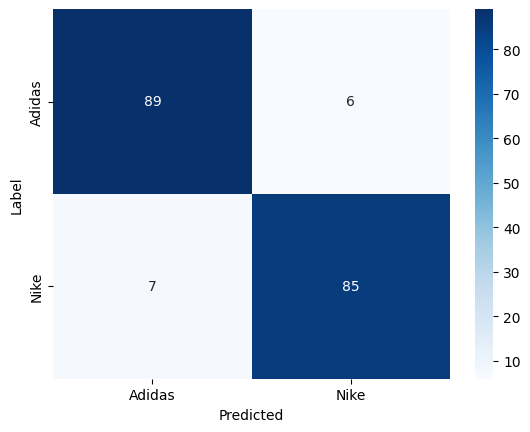

In [135]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, test_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, test_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, test_loader)

## Usabilidade de webcam

In [136]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

### Predição

In [137]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

### Predição das classes da webcam

In [138]:
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')

Image: print_1.png | Resnet Prediction: Nike
